In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
from constants import HOLE_CARD_DICT, HOLE_CARDS
from utils import find_dominated_hands, find_blocked_hands
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
# ev_data['avg_ev'] = ev_data.iloc[:,1:].mean(axis=1)

In [2]:
hand_chart = pd.read_excel('data/hand_chart.xlsx')
data = pd.read_csv('data/hole_card_data.csv')

In [3]:
G = nx.DiGraph()
for row in range(13):
    for col in range(13):
        hand = hand_chart.iloc[row, col]
        hand_attrs = data.loc[data.hand == hand].iloc[0]
        G.add_node(hand,
                   river_win_rate=hand_attrs['river_win_rate'],
                   connectedness=hand_attrs['connectedness'],
                   suited=hand_attrs['suited'],
                   pair=hand_attrs['pair'])

In [4]:
for source in G.nodes():
    blocked_hands_dict = find_blocked_hands(source)
    dominated_hands_dict = find_dominated_hands(source)
    for dest in G.nodes():
        blocks = 1.0 if dest in blocked_hands_dict else 0.0
        if blocks == 1.0:
            combinations_blocked = blocked_hands_dict[dest]
        else:
            combinations_blocked = 0.0
            
        dominates = 1.0 if dest in dominated_hands_dict else 0.0
        if dominates == 1.0:
            combinations_dominated = dominated_hands_dict[dest]
        else:
            combinations_dominated = 0.0

        G.add_edge(source, dest, 
                   blocks=blocks, 
                   dominates=dominates, 
                   combinations_blocked=combinations_blocked,
                   combinations_dominated=combinations_dominated)

In [5]:
results = {}
for node in G.nodes():
    dominates_count = 0
    combos_dominated = 0
    combos_blocked = 0
    blocks_count = 0
    for source, dest, data in G.out_edges(node, data=True):
        dominates_count += data['dominates']
        combos_blocked += data['combinations_blocked']
        blocks_count += data['blocks']
        combos_dominated += data['combinations_dominated']

    dominated_by_count = 0
    blocked_by_count = 0
    combos_blocked_by_count = 0
    combos_dominated_by_count = 0
    for source, dest, data in G.in_edges(node, data=True):
        dominated_by_count += data['dominates']
        combos_blocked_by_count += data['combinations_blocked']
        blocked_by_count+= data['blocks']
        combos_dominated_by_count += data['combinations_dominated']
    
    results[node] = {
            'dominates_count': dominates_count,
            "combos_dominated": combos_dominated,
            
            'blocks_count': blocks_count,
            'combos_blocked': combos_blocked,
            
            'blocked_by_count': blocked_by_count,
            'combos_blocked_by_count': combos_blocked_by_count,
            
            'dominated_by_count': dominated_by_count,
            "combos_dominated_by_count": combos_dominated_by_count
    }
    
df = pd.DataFrame.from_dict(results, orient='index')

In [7]:
df["dom_ratio"] = df['combos_dominated'] / np.where(df['combos_dominated_by_count'] == 0, 1, df['combos_dominated_by_count'])
df["block_ratio"] = df['combos_blocked'] / np.where(df['combos_blocked_by_count'] == 0, 1, df['combos_blocked_by_count'])
df["dom_block_ratio"] = df['combos_dominated'] / np.where(df['combos_blocked_by_count'] == 0, 1, df['combos_blocked_by_count'])

In [27]:
df['block_ratio'].value_counts()

1.980392    78
0.651613    78
1.311688    13
Name: block_ratio, dtype: int64

In [31]:
df['block_ratio_cat'] = np.select(
    condlist=[
        df['block_ratio'] > 1.5,
        (df['block_ratio'] > 1) & (df['block_ratio'] < 1.5),
        df['block_ratio'] < 1
        ],
    choicelist=[
        2,
        1,
        0
    ]
)

In [38]:
df[['block_ratio', 'dom_ratio','dom_block_ratio']].corr()

,block_ratio,dom_ratio,dom_block_ratio
block_ratio,1.000000,0.043289,0.683128
dom_ratio,0.043289,1.000000,0.052034
dom_block_ratio,0.683128,0.052034,1.000000


In [45]:
X = df[['block_ratio_cat', 'dom_ratio','dom_block_ratio']].values
X_normalized = (X - X.mean(axis=0)) / X.std(axis=0)

c:\Users\campb\miniconda3\envs\ai_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\campb\miniconda3\envs\ai_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\campb\miniconda3\envs\ai_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\campb\miniconda3\envs\ai_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn

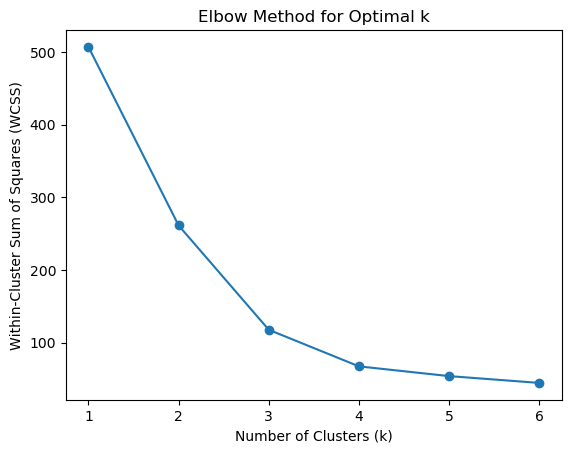

In [48]:
wcss = []
num_clusts = [1,2,3,4,5,6]
for k in num_clusts:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(X_normalized)
    wcss.append(kmeans.inertia_)

plt.plot(num_clusts, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [49]:
kmeans = KMeans(n_clusters=4, random_state=29)
df['cluster'] = kmeans.fit_predict(X_normalized)


c:\Users\campb\miniconda3\envs\ai_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


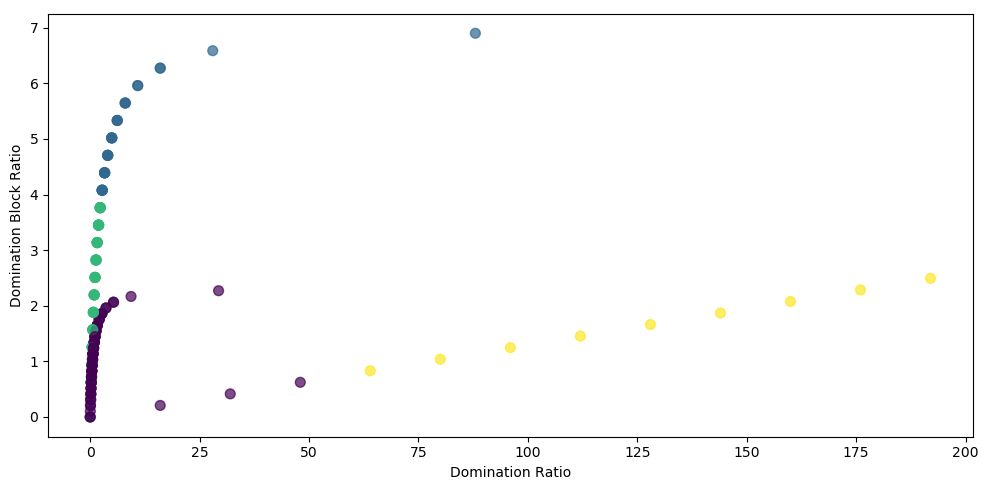

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(x=df['dom_ratio'], y=df['dom_block_ratio'],
        c=df['cluster'], 
        cmap='viridis',
        alpha=0.7,
        s=50
)
plt.xlabel('Domination Ratio')
plt.ylabel('Domination Block Ratio')
plt.tight_layout()
plt.show()

In [ ]:
df.index.name = "hand"
df.reset_index(inplace=True)

In [74]:
df.to_csv("data/dom_block_data.csv", index=False)